In [43]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from utils import *
from env import Environment
from main import Config
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Baseline: Fictitious Play Solving Two-Agents Dilemma
Payoff matrix:

| Tables      | Cooperation |  Defection |
|-------------|:-----------:|-----------:|
| Cooperation |   REWARD    | TEMPTATION |
| Defection   |   SUCKER    | PUNISHMENT |

In [2]:
N_EPISODES = 100
EPOCH = 100
seed = 42
np.random.seed(seed)

In [3]:
def two_agent_fictitious_play(payoff:Type.TensorType, reward:Type.TensorType, strategy:Type.TensorType, belief:Type.TensorType, epsilon:float=0.05, random:bool=False):
    # exploration
    for i in range(1,10):
        strategy[i,0] = np.random.randint(0,2)
        strategy[i,1] = np.random.randint(0,2)

        # update the empirical distribution
        belief[i,0] = ((i-1)*belief[i-1,0] + strategy[i,0])/i
        belief[i,1] = ((i-1)*belief[i-1,1] + strategy[i,1])/i

    for i in range(10,N_EPISODES):
        # calculate payoff of Agent 0 assuming the other Agent plays according to empirical dist.
        reward[0,0] = belief[i-1,1]*payoff[0,1] + (1-belief[i-1,1])*payoff[0,0]
        reward[1,0] = belief[i-1,1]*payoff[1,1] + (1-belief[i-1,1])*payoff[1,0]

        # calculate payoff of Agent 1 assuming the other Agent plays according to empirical dist.
        reward[0,1] = belief[i-1,0]*payoff[0,1] + (1-belief[i-1,0])*payoff[0,0]
        reward[1,1] = belief[i-1,0]*payoff[1,1] + (1-belief[i-1,0])*payoff[1,0]

        # Agent 1's best response
        if reward[0,0] < reward[1,0]-epsilon:
            strategy[i,0] = 1
        elif reward[0,0]-epsilon > reward[1,0]:
            strategy[i,0] = 0
        else:
            strategy[i,0] = strategy[i-1,0] if random==False else np.random.randint(0,2)

        # Agent 2's best response
        if  reward[0,1] < reward[1,1]-epsilon:
            strategy[i,1] = 1
        elif reward[0,1]-epsilon > reward[1,1]:
            strategy[i,1] = 0
        else:
            strategy[i,1] = strategy[i-1,1] if random==False else np.random.randint(0,2)

        # update the empirical distribution
        belief[i,0] = ((i-1)*belief[i-1,0] + strategy[i,0])/i
        belief[i,1] = ((i-1)*belief[i-1,1] + strategy[i,1])/i

        # store the (normalized) number of iterations
        # strategy[i,2] = i/N_EPISODES
        # belief[i,2] = i/N_EPISODES
    return strategy, belief

In [25]:
def generate_payoff_matrix(name:str, REWARD=3, TEMPTATION=None, SUCKER=None, PUNISHMENT=1, N=100):
    # prisoner's dilemma rule: TEMPTATION > REWARD > PUNISHMENT > SUCKER; 2*REWARD > TEMPTATION + SUCKER
    if REWARD is not None and TEMPTATION is not None and SUCKER is not None and PUNISHMENT is not None:
        return REWARD, TEMPTATION, SUCKER, PUNISHMENT
    if name == 'PD':
        TEMPTATION = np.round(np.random.uniform(REWARD+0.01, 2*REWARD-0.01, N), decimals=2)
        x = np.ones(N)
        REWARD = REWARD * x
        SUM = np.round(np.random.uniform(TEMPTATION, 2*REWARD-0.01, N), decimals=2)
        SUCKER = SUM - TEMPTATION
        PUNISHMENT = np.round(np.random.uniform(SUCKER+0.01, REWARD-0.01, N), decimals=2)
        assert np.sum(TEMPTATION > REWARD) == N and np.sum(REWARD > PUNISHMENT) == N and np.sum(PUNISHMENT > SUCKER) == N, f'{np.sum(TEMPTATION > REWARD)} and {np.sum(REWARD > PUNISHMENT)} and {np.sum(PUNISHMENT > SUCKER)}'
        assert np.sum(2*REWARD > TEMPTATION + SUCKER) == N, f'{np.sum(2*REWARD > TEMPTATION + SUCKER)}'
        return REWARD, TEMPTATION, SUCKER, PUNISHMENT
    if name == 'SH':
        # stag hunt rule: REWARD > TEMPTATION > PUNISHMENT > SUCKER; TEMPTATION + SUCKER > 2*PUNISHMENT
        x = np.ones(N)
        PUNISHMENT = PUNISHMENT * x
        SUCKER = np.round(np.random.uniform(0, PUNISHMENT-0.01, N), decimals=2)
        TEMPTATION = np.round(np.random.uniform(2*PUNISHMENT-SUCKER+0.01, 10-0.01, N), decimals=2)
        REWARD = np.round(np.random.uniform(TEMPTATION+0.01, 10, N), decimals=2)
        assert np.sum(REWARD > TEMPTATION) == N and np.sum(TEMPTATION > PUNISHMENT) == N and np.sum(PUNISHMENT > SUCKER) == N, f'{np.sum(REWARD > TEMPTATION)} and {np.sum(TEMPTATION > PUNISHMENT)} and {np.sum(PUNISHMENT > SUCKER)}'
        return REWARD, TEMPTATION, SUCKER, PUNISHMENT
    
def simulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT):
    # C:0, D:1
    df_result = pd.DataFrame(columns=['Agent_1', 'Agent_2', 'Agent_1_Belief', 'Agent_2_Belief', 'temptation', 'reward', 'punishment', 'sucker'])
    for idx, val in tqdm(enumerate(REWARD)):
        R, S, T, P = val, SUCKER[idx], TEMPTATION[idx], PUNISHMENT[idx]
        payoff = np.array([[R, S],[T, P]])
        strategy_list, belief_list = [],[]
        for ep in range(EPOCH):
            # 'reward' stores the payoff for each player, assuming the other player plays according to the empirical distribution
            reward = np.zeros([2,2])
            # 'strategy' stores the strategy played in each time period
            strategy = -np.ones([N_EPISODES,2])
            # 'belief' stores the empirical distribution at each time period, which is the defection probability
            belief = np.zeros([N_EPISODES,2])
            strategy, belief = two_agent_fictitious_play(payoff, reward, strategy, belief, epsilon=0)
            strategy_list.append(strategy[-1].copy())
            belief_list.append(belief[-1].copy())
        df = pd.DataFrame(np.concatenate((np.array(strategy_list),np.array(belief_list)), axis=1), columns=['Agent_1', 'Agent_2', 'Agent_1_Belief', 'Agent_2_Belief'])
        df_mean = df.mean().to_frame().transpose()
        df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
        df_result = pd.concat([df_result, df_mean], ignore_index=True)
    return df_result.astype(float)

PD results

1000it [01:16, 13.11it/s]


<AxesSubplot:ylabel='Frequency'>

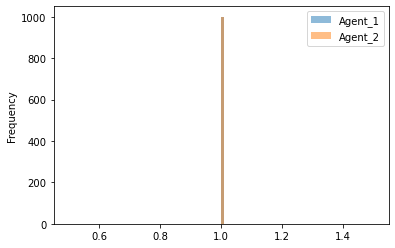

In [26]:
# prisoner's dilemma
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3, 5, 0, 1
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('PD', N=1000)
# stag hunt
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 3, 0, 1
# chicken
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3, 4, 1, 0
# payoff matrix for the two Agents in the 2x2 game
df_PD = simulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT)
df_PD[['Agent_1', 'Agent_2']].plot.hist(bins=100, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

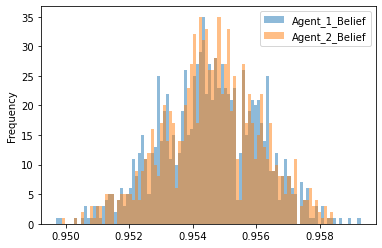

In [27]:
df_PD[['Agent_1_Belief', 'Agent_2_Belief']].plot.hist(bins=100, alpha=0.5)

Stag Hunt result

1000it [01:15, 13.19it/s]


<AxesSubplot:ylabel='Frequency'>

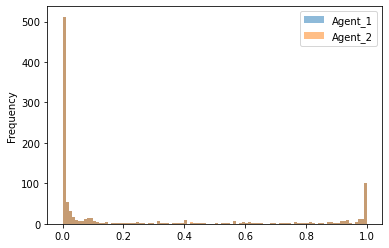

In [28]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('SH', N=1000)
# stag hunt
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 3, 0, 1

df_SH = simulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT)
df_SH[['Agent_1', 'Agent_2']].plot.hist(bins=100, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

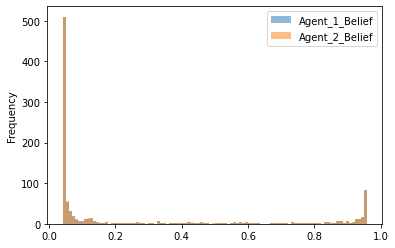

In [29]:
df_SH[['Agent_1_Belief', 'Agent_2_Belief']].plot.hist(bins=100, alpha=0.5)

In [37]:
df_SH.where((df_SH['Agent_1'] < 0.9) & (df_SH['Agent_1'] > 0.1)).dropna()

,Agent_1,Agent_2,Agent_1_Belief,Agent_2_Belief,temptation,reward,punishment,sucker
1,0.79,0.79,0.760202,0.760909,6.61,7.19,1.0,0.20
4,0.14,0.14,0.175455,0.173333,8.79,9.89,1.0,0.31
5,0.21,0.21,0.239697,0.240707,5.72,7.09,1.0,0.04
8,0.11,0.11,0.150202,0.147273,7.12,7.99,1.0,0.48
25,0.16,0.16,0.192323,0.193737,4.59,5.40,1.0,0.48
...,...,...,...,...,...,...,...,...
965,0.31,0.31,0.329192,0.329192,5.40,6.17,1.0,0.38
966,0.56,0.56,0.552727,0.553636,4.56,5.34,1.0,0.13
976,0.53,0.53,0.525556,0.526465,4.64,5.25,1.0,0.27
997,0.40,0.40,0.408889,0.408283,9.60,9.96,1.0,0.68


(0.0, 3.5)

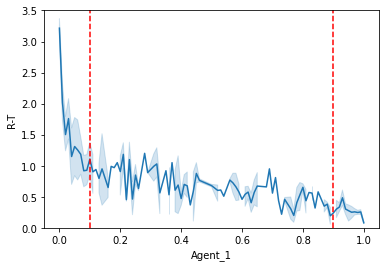

In [51]:
df_SH_convergent = df_SH.where((df_SH['Agent_1'] >= 0.9) | (df_SH['Agent_1'] <= 0.1)).dropna()
df_SH['R-T'] = df_SH['reward'] - df_SH['temptation']
sns.lineplot(data=df_SH, x='Agent_1', y='R-T')
plt.vlines(0.1, -0, 3.5, 'r', '--')
plt.vlines(0.9, -0, 3.5, 'r', '--')
plt.ylim(0,3.5)

(0.0, 8.001)

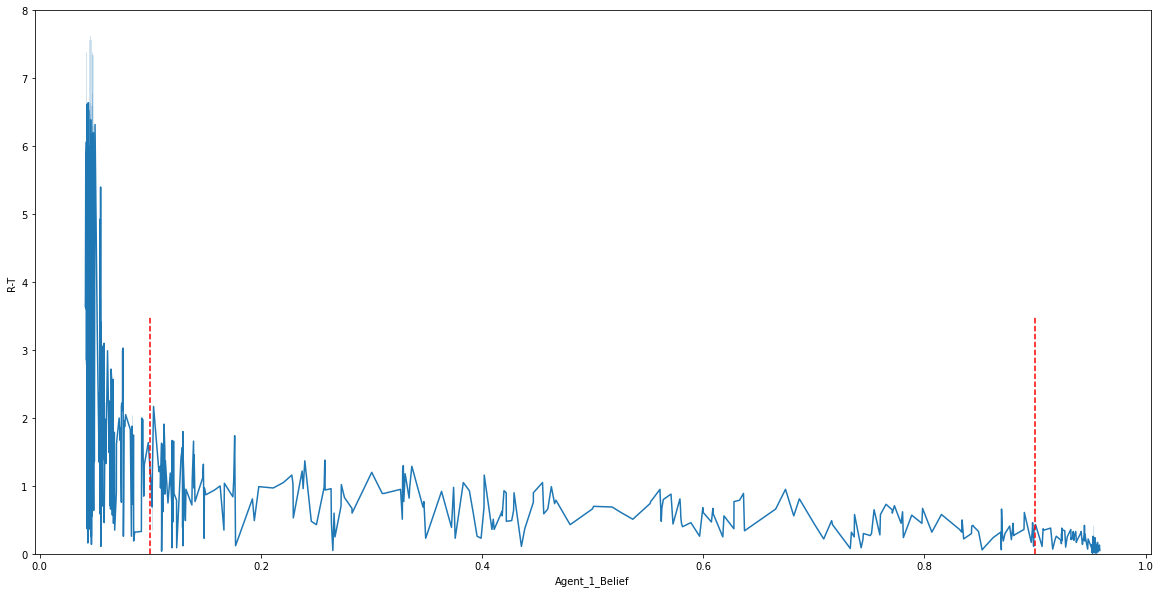

In [55]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=df_SH, x='Agent_1_Belief', y='R-T')
plt.vlines(0.1, -0, 3.5, 'r', '--')
plt.vlines(0.9, -0, 3.5, 'r', '--')
plt.ylim(0,)

(0.0, 10.0)

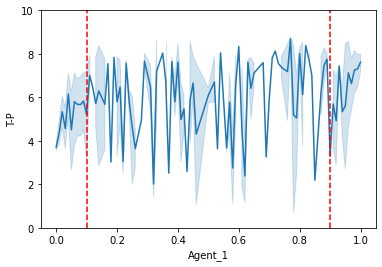

In [58]:
df_SH['T-P'] = df_SH['temptation'] - df_SH['punishment']
sns.lineplot(data=df_SH, x='Agent_1', y='T-P')
plt.vlines(0.1, -0, 10, 'r', '--')
plt.vlines(0.9, -0, 10, 'r', '--')
plt.ylim(0,10)

(0.0, 1.0)

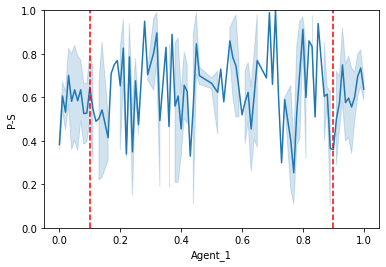

In [60]:
df_SH['P-S'] = df_SH['punishment'] - df_SH['sucker']
sns.lineplot(data=df_SH, x='Agent_1', y='P-S')
plt.vlines(0.1, -0, 10, 'r', '--')
plt.vlines(0.9, -0, 10, 'r', '--')
plt.ylim(0,1)

### Generalized into N-Agent Version

In [78]:
def multi_agent_fictitious_play(N_EPISODES:int, payoff:Type.TensorType, reward:Type.TensorType, strategy:Type.TensorType, belief:Type.TensorType, N:int, alpha:float=0.05, epsilon:float=0.05, random:bool=False):
    def random_select_partner(N:int, n:int):
        m = n
        while m == n:
            m = np.random.randint(0, N)
        return m

    assert strategy.shape == (N_EPISODES, N), f"strategy columns should be N, but {strategy.shape}"

    log=dict()
    final_strategy = np.zeros(N)
    # exploration
    for i in range(1,10):
        n = np.random.randint(0, N)
        m = random_select_partner(N,n)

        strategy[i,n] = np.random.randint(0,2)
        strategy[i,m] = np.random.randint(0,2)

        # update the empirical distribution
        belief[n] = (1-alpha)*belief[n] + alpha*strategy[i,n]
        belief[m] = (1-alpha)*belief[m] + alpha*strategy[i,m]
        log[i] = {n:belief[n],m:belief[m]}

    for i in range(10,N_EPISODES):
        n = np.random.randint(0, N)
        m = random_select_partner(N,n)

        # calculate payoff of Agent 0 assuming the other Agent plays according to empirical dist.
        reward[0,0] = belief[m]*payoff[0,1] + (1-belief[m])*payoff[0,0]
        reward[1,0] = belief[m]*payoff[1,1] + (1-belief[m])*payoff[1,0]

        # calculate payoff of Agent 1 assuming the other Agent plays according to empirical dist.
        reward[0,1] = belief[n]*payoff[0,1] + (1-belief[n])*payoff[0,0]
        reward[1,1] = belief[n]*payoff[1,1] + (1-belief[n])*payoff[1,0]

        # Agent 1's best response
        if reward[0,0] < reward[1,0]-epsilon:
            strategy[i,n] = 1
        elif reward[0,0]-epsilon > reward[1,0]:
            strategy[i,n] = 0
        else:
            strategy[i,n] = np.random.randint(0,2)

        # Agent 2's best response
        if  reward[0,1] < reward[1,1]-epsilon:
            strategy[i,m] = 1
        elif reward[0,1]-epsilon > reward[1,1]:
            strategy[i,m] = 0
        else:
            strategy[i,m] = np.random.randint(0,2)

        print('error') if strategy[i,n]<0 or strategy[i,m]<0 else None

        # update the empirical distribution
        belief[n] = (1-alpha)*belief[n] + alpha*strategy[i,n]
        belief[m] = (1-alpha)*belief[m] + alpha*strategy[i,m]
        log[i] = {n:belief[n],m:belief[m]}
        # store the (normalized) number of iterations
        # strategy[i,2] = i/N_EPISODES
        # belief[i,2] = i/N_EPISODES
    for i in range(N):
        j = -1
        while strategy[j,i] == -1:
            j -= 1
        final_strategy[i] = strategy[j,i]
    return strategy, belief, log, final_strategy

In [106]:
def multi_stimulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT, N_EPISODES, N, EPOCH):
    payoff = np.array([[REWARD, SUCKER],[TEMPTATION, PUNISHMENT]])
    strategy_list, belief_list = [],[]
    for ep in range(EPOCH):
        # 'reward' stores the payoff for each player, assuming the other player plays according to the empirical distribution
        reward = np.zeros([2,2])
        # 'strategy' stores the strategy played in each time period
        strategy = -np.ones([N_EPISODES,N])
        # 'belief' stores the empirical distribution at each time period, which is the defection probability
        belief = np.zeros(N)
        _, belief, belief_value, final_strategy = multi_agent_fictitious_play(N_EPISODES, payoff, reward, strategy, belief, N)
        strategy_list.append(final_strategy.copy())
        belief_list.append(belief.copy())

    columns = []
    for i in range(N):
        columns.append(f'Agent_{i+1}')
    for i in range(N):
        columns.append(f'Agent_{i+1}_Belief')

    df = pd.DataFrame(np.concatenate((np.array(strategy_list),np.array(belief_list)), axis=1), columns=columns)
    return df

In [110]:
# prisoner's dilemma
REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3.0, 5.8, 0.1, 3.3	
# stag hunt
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 3, 0, 1
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 4, 0, 1
# chicken
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3, 4, 1, 0

N = 3
EPOCH = 100
N_EPISODES = 1000
# C:0, D:1
# payoff matrix for the two players in the 2x2 game
df_multi_PD = multi_stimulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT, N_EPISODES, N, EPOCH)
df_multi_PD.describe()

,Agent_1,Agent_2,Agent_3,Agent_1_Belief,Agent_2_Belief,Agent_3_Belief
count,100.0,100.0,100.0,1.000000e+02,1.000000e+02,1.000000e+02
mean,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
std,0.0,0.0,0.0,1.839710e-15,2.959122e-15,2.186288e-15
min,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
50%,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
75%,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
max,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00


In [114]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('PD', N=100)
df_multi_PD = pd.DataFrame(columns=['Agent_1', 'Agent_2', 'Agent_3', 'Agent_1_Belief', 'Agent_2_Belief', 'Agent_3_Belief', 'temptation', 'reward', 'punishment', 'sucker'])
for idx, val in tqdm(enumerate(REWARD)):
    R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
    df = multi_stimulate(R, T, S, P, N_EPISODES, N, EPOCH)
    df_mean = df.mean().to_frame().transpose()
    df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
    df_multi_PD = pd.concat([df_multi_PD, df_mean], ignore_index=True)
df_multi_PD = df_multi_PD.astype(float)

100it [02:03,  1.23s/it]


<AxesSubplot:ylabel='Frequency'>

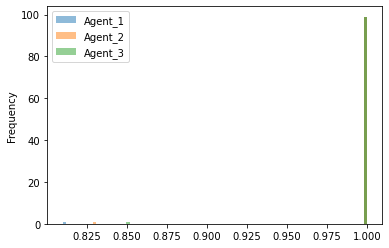

In [120]:
df_multi_PD
df_multi_PD[['Agent_1', 'Agent_2', 'Agent_3']].plot.hist(bins=100, alpha=0.5)

In [136]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('PD', N=100)
for N in range(4,10):
    df_multi_PD = pd.DataFrame(columns=['temptation', 'reward', 'punishment', 'sucker'])
    for idx, val in tqdm(enumerate(REWARD)):
        R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
        df = multi_stimulate(R, T, S, P, N_EPISODES, N, EPOCH)
        df_mean = df.mean().to_frame().transpose()
        df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
        df_multi_PD = pd.concat([df_multi_PD, df_mean], ignore_index=True)
    df_multi_PD = df_multi_PD.astype(float)
    if sum(df_multi_PD['Agent_1'] < 0.9) >= 10 or sum(df_multi_PD['Agent_1_Belief'] < 0.9) >= 10:
        print(df_multi_PD.mean())

100it [01:51,  1.11s/it]
100it [01:50,  1.10s/it]
100it [01:48,  1.09s/it]
100it [01:48,  1.08s/it]
100it [01:51,  1.11s/it]
100it [01:56,  1.16s/it]


In [141]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('SH', N=1000)
df_multi_SH = pd.DataFrame(columns=['Agent_1', 'Agent_2', 'Agent_3', 'Agent_1_Belief', 'Agent_2_Belief', 'Agent_3_Belief', 'temptation', 'reward', 'punishment', 'sucker'])
for idx, val in tqdm(enumerate(REWARD)):
    R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
    df = multi_stimulate(R, T, S, P, N_EPISODES, N, EPOCH)
    df_mean = df.mean().to_frame().transpose()
    df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
    df_multi_SH = pd.concat([df_multi_SH, df_mean], ignore_index=True)
df_multi_SH = df_multi_SH.astype(float)
df_multi_SH.describe()

1000it [19:50,  1.19s/it]


,Agent_1,Agent_2,Agent_3,Agent_1_Belief,Agent_2_Belief,Agent_3_Belief,temptation,reward,punishment,sucker,...,Agent_6,Agent_7,Agent_8,Agent_9,Agent_4_Belief,Agent_5_Belief,Agent_6_Belief,Agent_7_Belief,Agent_8_Belief,Agent_9_Belief
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.0,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,0.045970,0.045900,0.046040,4.599405e-02,4.599163e-02,4.596058e-02,5.904150,8.034130,1.0,0.494940,...,0.045970,0.045900,0.046000,0.045970,4.600022e-02,4.599603e-02,4.598850e-02,4.599747e-02,4.598680e-02,4.599817e-02
std,0.202658,0.202586,0.202853,2.027379e-01,2.027212e-01,2.026687e-01,2.400365,1.804664,0.0,0.282604,...,0.202739,0.202546,0.202804,0.202675,2.027500e-01,2.027396e-01,2.027273e-01,2.027393e-01,2.027041e-01,2.027486e-01
min,0.000000,0.000000,0.000000,4.779906e-07,4.838600e-07,4.717136e-07,1.190000,1.880000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.208059e-07,4.654314e-07,4.315756e-07,4.581265e-07,4.441901e-07,4.738023e-07
25%,0.000000,0.000000,0.000000,6.822597e-07,6.885978e-07,6.846164e-07,3.920000,6.970000,1.0,0.250000,...,0.000000,0.000000,0.000000,0.000000,6.806992e-07,6.833831e-07,6.808592e-07,6.841178e-07,6.855955e-07,6.900631e-07
50%,0.000000,0.000000,0.000000,7.567363e-07,7.615567e-07,7.531805e-07,5.965000,8.600000,1.0,0.500000,...,0.000000,0.000000,0.000000,0.000000,7.526721e-07,7.516921e-07,7.553243e-07,7.540499e-07,7.576607e-07,7.554718e-07
75%,0.000000,0.000000,0.000000,8.343537e-07,8.450351e-07,8.286028e-07,7.950000,9.490000,1.0,0.730000,...,0.000000,0.000000,0.000000,0.000000,8.338981e-07,8.316162e-07,8.356885e-07,8.339691e-07,8.402519e-07,8.257686e-07
max,1.000000,1.000000,1.000000,9.999853e-01,9.999860e-01,9.999850e-01,9.990000,10.000000,1.0,0.990000,...,1.000000,1.000000,1.000000,1.000000,9.999861e-01,9.999856e-01,9.999866e-01,9.999859e-01,9.999868e-01,9.999857e-01


(0.0, 3.5)

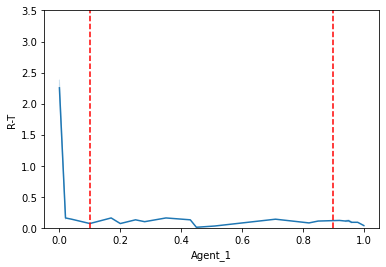

In [143]:
df_multi_SH['R-T'] = df_multi_SH['reward'] - df_multi_SH['temptation']
sns.lineplot(data=df_multi_SH, x='Agent_1', y='R-T')
plt.vlines(0.1, -0, 3.5, 'r', '--')
plt.vlines(0.9, -0, 3.5, 'r', '--')
plt.ylim(0,3.5)

In [ ]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('SH', N=100)
for N in range(4,10):
    df_multi_PD = pd.DataFrame(columns=['temptation', 'reward', 'punishment', 'sucker'])
    for idx, val in tqdm(enumerate(REWARD)):
        R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
        df = multi_stimulate(R, T, S, P, N_EPISODES, N, EPOCH)
        df_mean = df.mean().to_frame().transpose()
        df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
        df_multi_PD = pd.concat([df_multi_PD, df_mean], ignore_index=True)
    df_multi_PD = df_multi_PD.astype(float)
    print(df_multi_PD.mean())